# Business Case Analysis

In this business case analysis I am using an online retail store dataset found in the [Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Online+Retail). The aim of this dataset is to identify models of purchases across the time. I will perform in this dataset:
- Apply descriptive analytics to understand data behavior.
- Apply NLP to identify groups of products.
- Apply forecasting

In [139]:
import pandas as pd
from pandas import ExcelFile
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sys
from pandas.plotting import autocorrelation_plot
import warnings
import statsmodels.api as sm
import seaborn as sns
from fbprophet import Prophet
from dateutil.relativedelta import relativedelta
import datetime

In [2]:
data_original = pd.read_csv('Online Retail.csv')

In [3]:
data_original

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# Descriptive Analytics

In [4]:
data_original['Total_Price'] = data_original['Quantity'] * data_original['UnitPrice']

In [5]:
data_invoice = data_original[['InvoiceNo','Quantity','Total_Price']]

In [6]:
data_original

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60


In [7]:
# Get attributes per Invoice
grp_invoice = data_invoice.groupby(['InvoiceNo']).sum()

In [8]:
grp_invoice.columns = ['Quantity','Total_Price']

### Quantity analysis

In [9]:
grp_invoice['Quantity']

InvoiceNo
536365        40
536366        12
536367        83
536368        15
536369         3
           ...  
C581484   -80995
C581490      -23
C581499       -1
C581568       -5
C581569       -6
Name: Quantity, Length: 25900, dtype: int64

In [10]:
#Invoice with the biggest amount of articles
grp_invoice['Quantity'].max()

80995

In [11]:
#Invoice with the less amount of articles
grp_invoice['Quantity'].min()

-80995

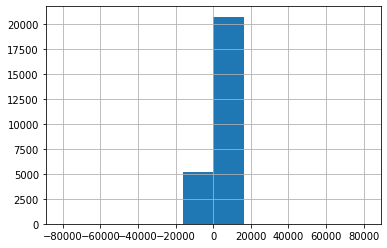

In [12]:
#Invoice quantity distribution, it seems to have a tendency of a normal distribution.
grp_invoice['Quantity'].hist()

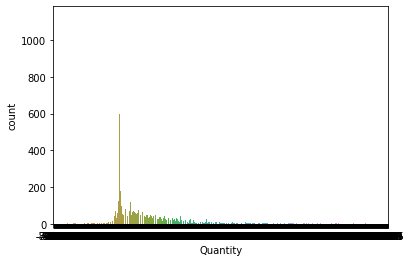

In [13]:
ax = sns.countplot(x="Quantity",data=grp_invoice)

In [14]:
#standard deviation
grp_invoice['Quantity'].std()

1108.563550956012

In [15]:
#mean
grp_invoice['Quantity'].mean()

199.86293436293437

In [16]:
#median
grp_invoice['Quantity'].median()

100.0

In [17]:
#q1
grp_invoice['Quantity'].quantile(0.25)

6.0

In [18]:
#q3
grp_invoice['Quantity'].quantile(0.75)

240.0

In [19]:
#IQR 
grp_invoice['Quantity'].quantile(0.75) - grp_invoice['Quantity'].quantile(0.25)

234.0

### Total_Price Analysis

In [20]:
grp_invoice['Total_Price']

InvoiceNo
536365        139.12
536366         22.20
536367        278.73
536368         70.05
536369         17.85
             ...    
C581484   -168469.60
C581490       -32.53
C581499      -224.69
C581568       -54.75
C581569        -7.50
Name: Total_Price, Length: 25900, dtype: float64

In [21]:
grp_invoice['Total_Price'].min()

-168469.6

In [22]:
grp_invoice['Total_Price'].max()

168469.6

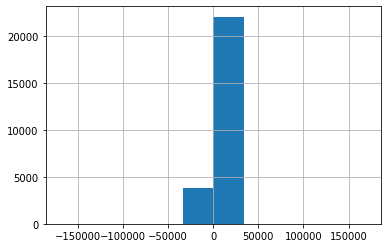

In [23]:
grp_invoice['Total_Price'].hist()

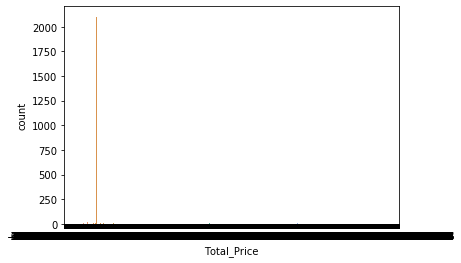

In [24]:
ax = sns.countplot(x="Total_Price",data=grp_invoice)

In [25]:
#standard deviation
grp_invoice['Total_Price'].std()

2013.2610500982398

In [26]:
#unit price mean
grp_invoice['Total_Price'].mean()

376.3609240926716

In [27]:
#unit price median
grp_invoice['Total_Price'].median()

207.53500000000003

In [28]:
#q1
grp_invoice['Total_Price'].quantile(0.25)

11.775000000000002

In [29]:
#q3
grp_invoice['Total_Price'].quantile(0.75)

409.08500000000004

In [30]:
#iqr
grp_invoice['Total_Price'].quantile(0.75) - grp_invoice['Total_Price'].quantile(0.25)

397.31000000000006

### Customer id analysis amount of purchases

In [31]:
customer_purchase = data_original[['CustomerID','Total_Price']]

In [32]:
customer_purchase

,CustomerID,Total_Price
0,17850.0,15.30
1,17850.0,20.34
2,17850.0,22.00
3,17850.0,20.34
4,17850.0,20.34
...,...,...
541904,12680.0,10.20
541905,12680.0,12.60
541906,12680.0,16.60
541907,12680.0,16.60


In [33]:
#count the number of purchases per customer
number_purchases_per_customer = customer_purchase['CustomerID'].value_counts()

In [34]:
number_purchases_per_customer

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
13391.0       1
16579.0       1
13366.0       1
17763.0       1
17846.0       1
Name: CustomerID, Length: 4372, dtype: int64

In [35]:
#Purchase with the maximum amount of money.

print(f'customer number_purchases {number_purchases_per_customer.max()}')

customer number_purchases 7983


In [36]:
#Purchase with the minimum amount of money.

print(f'customer number_purchases {number_purchases_per_customer.min()}')

customer number_purchases 1


In [37]:
#Purchases standard deviation of purchases.
number_purchases_per_customer.std()

232.47160774164695

In [38]:
#Purchases mean.
number_purchases_per_customer.mean()

93.05329368709972

In [39]:
#Purchases median.
number_purchases_per_customer.median()

42.0

In [40]:
#Purchases q1.
number_purchases_per_customer.quantile(0.25)

17.0

In [41]:
#Purchases q3.
number_purchases_per_customer.quantile(0.75)

102.0

In [42]:
#iqr amount of purchases
number_purchases_per_customer.quantile(0.75) - number_purchases_per_customer.quantile(0.25)

85.0

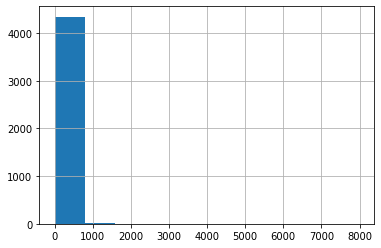

In [43]:
#looks like a skewed distribution to the left the amount of purchases made by each customer.
number_purchases_per_customer.hist()

 ### Customer id analysis amount of money spent per purchase

In [44]:
customer_spent = customer_purchase.groupby('CustomerID').agg(sum)

In [45]:
customer_spent.columns = ['Total_Price']

In [46]:
customer_spent

,Total_Price
CustomerID,
12346.0,0.00
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40
...,...
18280.0,180.60
18281.0,80.82
18282.0,176.60


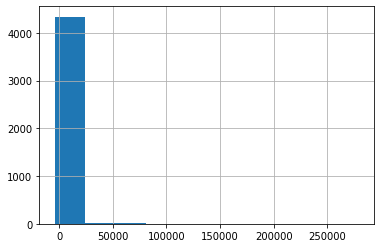

In [47]:
#amount of money spent per customer distribution. It has a skewed distribution to the left.
customer_spent['Total_Price'].hist()

In [48]:
#The highest amount of money spent per customer.
customer_spent[customer_spent['Total_Price'] == customer_spent['Total_Price'].max()]

,Total_Price
CustomerID,
14646.0,279489.02


In [49]:
#The least amount of money spent per customer.
customer_spent[customer_spent['Total_Price'] == customer_spent['Total_Price'].min()]

,Total_Price
CustomerID,
17448.0,-4287.63


In [50]:
#the standard deviation
customer_spent['Total_Price'].std()

8219.345141066593

In [51]:
#the mean
customer_spent['Total_Price'].mean()

1898.4597012808808

In [52]:
#the median
customer_spent['Total_Price'].median()

648.0750000000002

In [53]:
#q1
customer_spent['Total_Price'].quantile(0.25)

293.36250000000007

In [54]:
#q3
customer_spent['Total_Price'].quantile(0.75)

1611.7249999999995

In [55]:
#iqr
customer_spent['Total_Price'].quantile(0.75) - customer_spent['Total_Price'].quantile(0.25)

1318.3624999999993

### Purchases per Country Analysis

In [56]:
data_country = data_original[['Country','Quantity','Total_Price']]

In [57]:
#How many different countries do I have?
data_country['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [58]:
len(data_country['Country'].unique())

38

In [59]:
#What is the total amount of money per country?
data_country_sum = data_original[['Country','Total_Price']].groupby('Country').agg(sum)

In [60]:
data_country_sum

,Total_Price
Country,
Australia,1.370773e+05
Austria,1.015432e+04
Bahrain,5.484000e+02
Belgium,4.091096e+04
Brazil,1.143600e+03
Canada,3.666380e+03
Channel Islands,2.008629e+04
Cyprus,1.294629e+04
Czech Republic,7.077200e+02


In [61]:
#Which is the country with more sales?
data_country_sum[data_country_sum['Total_Price'] == data_country_sum['Total_Price'].max()]

,Total_Price
Country,
United Kingdom,8.187806e+06


In [62]:
#Which is the country with less sales?
data_country_sum[data_country_sum['Total_Price'] == data_country_sum['Total_Price'].min()]

,Total_Price
Country,
Saudi Arabia,131.17


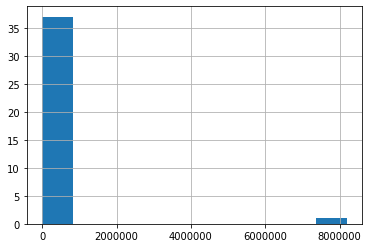

In [63]:
#How is the distribution of my total sales? Skewed to the left.
data_country_sum['Total_Price'].hist()

In [64]:
#Total sales std
data_country_sum['Total_Price'].std()

1323505.6852444275

In [65]:
#Total sales mean
data_country_sum['Total_Price'].mean()

256519.6824737134

In [66]:
#Total sales median
data_country_sum['Total_Price'].median()

10135.68

In [67]:
#Total sales q1
data_country_sum['Total_Price'].quantile(0.25)

2053.0775000000003

In [68]:
#Total sales q3
data_country_sum['Total_Price'].quantile(0.75)

36282.0875

In [69]:
#Total sales iqr
data_country_sum['Total_Price'].quantile(0.75) - data_country_sum['Total_Price'].quantile(0.25)

34229.01

In [70]:
#What is the average amount of money per country?
data_country_avg = data_original[['Country','Total_Price']].groupby('Country').agg(np.mean)

In [71]:
data_country_avg

,Total_Price
Country,
Australia,108.877895
Austria,25.322494
Bahrain,28.863158
Belgium,19.773301
Brazil,35.737500
Canada,24.280662
Channel Islands,26.499063
Cyprus,20.813971
Czech Republic,23.590667


In [72]:
#Which is the country with more average in sales?
data_country_avg[data_country_avg['Total_Price'] == data_country_avg['Total_Price'].max()]

,Total_Price
Country,
Netherlands,120.059696


In [73]:
#Which is the country with less average in sales?
data_country_avg[data_country_avg['Total_Price'] == data_country_avg['Total_Price'].min()]

,Total_Price
Country,
USA,5.948179


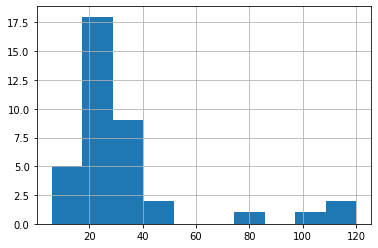

In [74]:
#How is the distribution of my average sales? Skewed to the left, but it might be possible that 
#it turn out to be a nice bell shape distribution.
data_country_avg['Total_Price'].hist()

In [75]:
#Total sales std
data_country_avg['Total_Price'].std()

25.63642076022049

In [76]:
#Total sales mean
data_country_avg['Total_Price'].mean()

33.93092988302741

In [77]:
#Total sales median
data_country_avg['Total_Price'].median()

25.910778545062115

In [78]:
#Total sales q1
data_country_avg['Total_Price'].quantile(0.25)

21.063920077933556

In [79]:
#Total sales q3
data_country_avg['Total_Price'].quantile(0.75)

34.44117748618786

In [80]:
#Total sales iqr
data_country_avg['Total_Price'].quantile(0.75) - data_country_avg['Total_Price'].quantile(0.25)

13.377257408254305

### Timestamp Analysis

In [81]:
data_original['InvoiceDate'].sort_values(ascending=False)

332548      9/9/2011 9:52
332571      9/9/2011 9:52
332551      9/9/2011 9:52
332550      9/9/2011 9:52
332549      9/9/2011 9:52
               ...       
50815     1/10/2011 10:32
50828     1/10/2011 10:32
50808     1/10/2011 10:08
50807     1/10/2011 10:07
50806     1/10/2011 10:04
Name: InvoiceDate, Length: 541909, dtype: object

### Product Price Analysis

In [82]:
#What is the price of a product that people try to buy the most?
prices = data_original['UnitPrice'].value_counts()
data_original['UnitPrice'][prices.max()]

2.51

In [83]:
#What is the price of a product that people try to buy less?
data_original['UnitPrice'][prices.min()]

3.39

### Descriptive Analytics Summary

From the descriptive analytics from above we can infer the next information:
	* The amount of times that the customer goes into the store/website and buy something is 93.
	* The average amount of money spent per customer is 322.
	* The average amount of articles that each customer buys is 199.
	* We have 38 countries in total.
	* The country with more total sales is United kingdom.
	* The country with less total sales is Saudi Arabia.
	* The country with the highest average sales is Netherlands.
	* The country with the less average sales is USA.
    * The price of products that people tend to buy the most is 2.51.
    * The price of products that people tend to buy the least is 3.39.
	* We around 2 years of information, this means that we are able to really catch seasonallity effects and a trend, for just one year. Given the conditions, I decided to use prophet to do a forecast of next 3 months for United Kingdom and Netherlands of the total amount of sales.
	* From the information above we can infer as well that United kingdom has a lot of good wholesale customers, because the mean and median are very far appart from each other. On the other hand Netherlands has a lot of direct sales because the mean and the median are close to each other. 

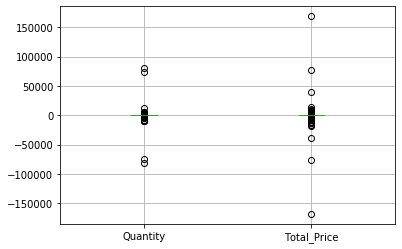

In [84]:
boxplot = data_original.boxplot(column=['Quantity', 'Total_Price'])

# Apply Natural Language Processing

For this kind of task, I am going to need to implement a bag of words algorithm with a clustering technique over my descriptions to check how well my cluster fill in categories. The main idea is to identify categories over my products and been able to add more insights based on the purchases made per category.

In [85]:
#TODO ADD NLP
#Todo try to implement a xgboost

# Time Series

In this case I am going to do a small forecast over my series with the overall sales per month. I am going to forecast the next 3 months of sales.

In [86]:
#Todo add the time series
data_original_for = pd.read_csv('Online Retail.csv')
data_original_for['Total_Price'] = data_original_for['Quantity'] * data_original_for['UnitPrice']

In [87]:
data_original_for

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60


In [88]:
type(data_original_for['InvoiceDate'][0])

str

In [89]:
data_original_for['InvoiceDate'] = pd.to_datetime(data_original_for['InvoiceDate'])

In [90]:
type(data_original_for['InvoiceDate'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [91]:
def get_month(date):
    return date.month
data_original_for['InvoiceDate_Month'] = list(map(get_month,data_original_for['InvoiceDate']))

In [92]:
def get_year(date):
    return date.year
data_original_for['InvoiceDate_Year'] = list(map(get_year,data_original_for['InvoiceDate']))

In [93]:
data_original_for

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,InvoiceDate_Month,InvoiceDate_Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,12,2011
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,12,2011
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,12,2011
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,12,2011


In [94]:
data_forecasting = data_original_for[['Country','Total_Price','InvoiceDate_Month','InvoiceDate_Year']].groupby(['Country','InvoiceDate_Year','InvoiceDate_Month']).agg(sum)

In [95]:
data_forecasting

Total_Price
Country     InvoiceDate_Year InvoiceDate_Month             
Australia   2010             12                     1005.10
            2011             1                      9017.71
                             2                     14627.47
                             3                     17055.29
                             4                       333.40
...                                                     ...
Unspecified 2011             6                       185.78
                             7                      1425.41
                             8                       531.03
                             9                       286.85
                             11                      965.75

[314 rows x 1 columns]

In [96]:
united_kingdom = data_forecasting[data_forecasting.index.get_level_values(0) == 'United Kingdom']

In [97]:
united_kingdom

Total_Price
Country        InvoiceDate_Year InvoiceDate_Month             
United Kingdom 2010             12                  676742.620
               2011             1                   434308.300
                                2                   408247.910
                                3                   559707.390
                                4                   442254.041
                                5                   596459.860
                                6                   554478.350
                                7                   565479.841
                                8                   539130.500
                                9                   862018.152
                                10                  877438.190
                                11                 1282805.780
                                12                  388735.430

In [98]:
dates = pd.DataFrame({'year':united_kingdom.index.get_level_values(1),'month':united_kingdom.index.get_level_values(2)})

In [99]:
dates['day'] = 1

In [100]:
dates 

,year,month,day
0,2010,12,1
1,2011,1,1
2,2011,2,1
3,2011,3,1
4,2011,4,1
5,2011,5,1
6,2011,6,1
7,2011,7,1
8,2011,8,1
9,2011,9,1


In [101]:
dates_col = pd.to_datetime(dates)

In [102]:
dates_col

0    2010-12-01
1    2011-01-01
2    2011-02-01
3    2011-03-01
4    2011-04-01
5    2011-05-01
6    2011-06-01
7    2011-07-01
8    2011-08-01
9    2011-09-01
10   2011-10-01
11   2011-11-01
12   2011-12-01
dtype: datetime64[ns]

In [103]:
uk_for = pd.DataFrame({'dates':dates_col,'Total_Price':united_kingdom['Total_Price'].values})

In [104]:
uk_for

,dates,Total_Price
0,2010-12-01,676742.620
1,2011-01-01,434308.300
2,2011-02-01,408247.910
3,2011-03-01,559707.390
4,2011-04-01,442254.041
5,2011-05-01,596459.860
6,2011-06-01,554478.350
7,2011-07-01,565479.841
8,2011-08-01,539130.500
9,2011-09-01,862018.152


In [122]:
#I am going to fit my model up to the 18 month in such way that I am able to measure the performance.
uk_for_train = uk_for.iloc[:9,:]

In [123]:
uk_for_train

,dates,Total_Price
0,2010-12-01,676742.620
1,2011-01-01,434308.300
2,2011-02-01,408247.910
3,2011-03-01,559707.390
4,2011-04-01,442254.041
5,2011-05-01,596459.860
6,2011-06-01,554478.350
7,2011-07-01,565479.841
8,2011-08-01,539130.500


In [124]:
uk_for_train.columns = ['ds','y']

In [125]:
uk_for

,dates,Total_Price
0,2010-12-01,676742.620
1,2011-01-01,434308.300
2,2011-02-01,408247.910
3,2011-03-01,559707.390
4,2011-04-01,442254.041
5,2011-05-01,596459.860
6,2011-06-01,554478.350
7,2011-07-01,565479.841
8,2011-08-01,539130.500
9,2011-09-01,862018.152


TypeError: 'module' object is not callable

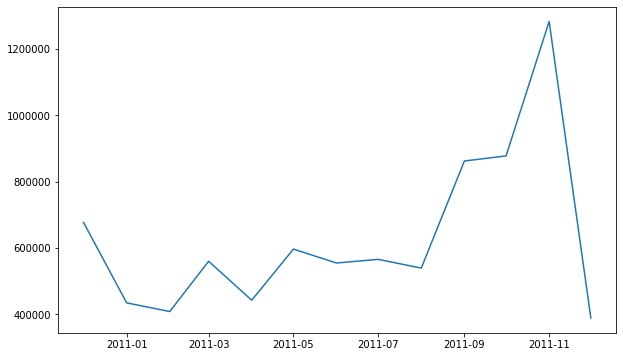

In [142]:
df['Datetime'] = df.index
melted_df = pd.melt(df, id_vars='Datetime', var_name='Security', value_name='Price')
melted_df['Dummy'] = 0

sns.tsplot(melted_df, time='Datetime', unit='Dummy', condition='Security', value='Price', ax=ax)

In [126]:
uk_for_test = uk_for.iloc[9:,:]

In [127]:
uk_for_test

,dates,Total_Price
9,2011-09-01,862018.152
10,2011-10-01,877438.190
11,2011-11-01,1282805.780
12,2011-12-01,388735.430


In [129]:
uk_for_test_dt = list(uk_for_test['dates'])
uk_for_test_pr = list(uk_for_test['Total_Price'])

In [130]:
for item in range(1,4):
     mon_rel = relativedelta(months=item)
     uk_for_test_dt.append(uk_for_test_dt[3] + mon_rel)
     uk_for_test_pr.append(item)

In [131]:
uk_for_test = pd.DataFrame({'ds':uk_for_test_dt,'y':uk_for_test_pr})

In [132]:
uk_for_test

,ds,y
0,2011-09-01,862018.152
1,2011-10-01,877438.190
2,2011-11-01,1282805.780
3,2011-12-01,388735.430
4,2012-01-01,1.000
5,2012-02-01,2.000
6,2012-03-01,3.000


In [133]:
model = Prophet()

In [134]:
model.fit(uk_for_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


In [135]:
predict = model.predict(uk_for_test)

In [151]:
predict_result = predict.iloc[:4,:]

In [152]:
predict_result

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-09-01,545920.666003,440974.776239,645797.195252,545920.665394,545920.666582,0.0,0.0,0.0,0.0,0.0,0.0,545920.666003
1,2011-10-01,548786.727053,440829.912097,655058.661084,548786.725062,548786.729120,0.0,0.0,0.0,0.0,0.0,0.0,548786.727053
2,2011-11-01,551748.323471,450535.231610,645613.207902,551748.319460,551748.327643,0.0,0.0,0.0,0.0,0.0,0.0,551748.323471
3,2011-12-01,554614.384521,454120.665778,665906.970397,554614.378116,554614.390687,0.0,0.0,0.0,0.0,0.0,0.0,554614.384521


In [153]:
y_true_result = uk_for_test.iloc[:4,:]

In [154]:
y_true_result

,ds,y
0,2011-09-01,862018.152
1,2011-10-01,877438.190
2,2011-11-01,1282805.780
3,2011-12-01,388735.430


In [155]:
#Todo configure timeseries properties, perform proper analysis over the serie. Seasonality, trend etc. Configure outliers.

In [145]:
#check the awful mape.
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [158]:
mape = mean_absolute_percentage_error(y_true_result['y'],predict_result['yhat'])

In [159]:
mape

43.44640906819261